# Topological Criticality Analysis with Impact-Based Validation

## Refined Methodology

This notebook demonstrates an improved approach that separates **prediction** from **validation**:

### **Composite Criticality Score (Pure Topology)**
$$C_{\text{score}}(v) = \alpha \cdot C_B^{\text{norm}}(v) + \beta \cdot AP(v)$$

Where:
- $C_B^{\text{norm}}(v) \in [0,1]$ = normalized betweenness centrality
- $AP(v) \in \{0,1\}$ = articulation point indicator
- $\alpha = 0.6, \beta = 0.4$ (default weights)

### **Impact Score (Validation Ground Truth)**
$$I(v) = 1 - \frac{|R(G-v)|}{|R(G)|}$$

Where $R(G)$ = set of all reachable vertex pairs

### **Topic Importance (Context)**
QoS policies inform which components are important for interpretation, but do NOT directly affect criticality scores.

---

## Why This Approach Makes Sense

1. **Scientific Rigor**: Separating prediction (topology) from validation (actual impact)
2. **Computational Efficiency**: Impact calculation is O(n²) - only computed for validation
3. **Clear Interpretation**: Topology predicts criticality; impact validates the prediction
4. **Falsifiability**: If correlation is low, we know the approach needs refinement
5. **Practical Utility**: Fast topology-based scoring for real-time analysis; slower impact calculation for periodic validation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import pearsonr, spearmanr
from typing import Dict, List, Set
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("✓ Environment ready")

✓ Environment ready


## 1. Create Sample System

Generate a realistic pub-sub system for demonstration.

In [2]:
def create_pubsub_system() -> nx.DiGraph:
    """
    Create a representative pub-sub system
    """
    G = nx.DiGraph()
    
    # Physical nodes
    for i in range(1, 6):
        G.add_node(f'Node{i}', type='Node', name=f'Node{i}')
    
    # Node connectivity
    connections = [(1,2), (2,3), (3,4), (4,5), (1,5), (2,4)]
    for i, j in connections:
        G.add_edge(f'Node{i}', f'Node{j}', type='CONNECTS_TO')
        G.add_edge(f'Node{j}', f'Node{i}', type='CONNECTS_TO')
    
    # Brokers
    for i in range(1, 3):
        G.add_node(f'Broker{i}', type='Broker', name=f'Broker{i}')
        G.add_edge(f'Broker{i}', f'Node{i}', type='RUNS_ON')
    
    # Topics with QoS
    topics = [
        ('T1', 'payment/orders', 'PERSISTENT', 'RELIABLE', 0.95),
        ('T2', 'user/events', 'TRANSIENT_LOCAL', 'RELIABLE', 0.75),
        ('T3', 'metrics/system', 'VOLATILE', 'BEST_EFFORT', 0.40),
        ('T4', 'notifications', 'TRANSIENT', 'RELIABLE', 0.65),
        ('T5', 'inventory/updates', 'PERSISTENT', 'RELIABLE', 0.90)
    ]
    
    for tid, name, dur, rel, importance in topics:
        G.add_node(tid, type='Topic', name=name, durability=dur, 
                  reliability=rel, qos_importance=importance)
        broker = 'Broker1' if int(tid[1]) % 2 == 1 else 'Broker2'
        G.add_edge(broker, tid, type='ROUTES')
    
    # Applications with pub/sub patterns
    apps = [
        ('PaymentService', 'Node1', ['T1'], ['T5']),
        ('UserService', 'Node2', ['T2'], ['T1', 'T4']),
        ('MetricsCollector', 'Node3', ['T3'], ['T1', 'T2', 'T5']),
        ('NotificationService', 'Node3', ['T4'], ['T2', 'T5']),
        ('InventoryService', 'Node4', ['T5'], ['T1']),
        ('APIGateway', 'Node1', [], ['T1', 'T2', 'T3', 'T4']),
        ('OrderProcessor', 'Node2', [], ['T1', 'T5']),
        ('AnalyticsEngine', 'Node5', [], ['T3', 'T5']),
    ]
    
    for app, node, pubs, subs in apps:
        G.add_node(app, type='Application', name=app)
        G.add_edge(app, node, type='RUNS_ON')
        for t in pubs:
            G.add_edge(app, t, type='PUBLISHES_TO')
        for t in subs:
            G.add_edge(app, t, type='SUBSCRIBES_TO')
    
    # Create DEPENDS_ON relationships
    for app1, _, pubs, _ in apps:
        for topic in pubs:
            for app2, _, _, subs in apps:
                if app1 != app2 and topic in subs:
                    G.add_edge(app2, app1, type='DEPENDS_ON')
    
    return G

G = create_pubsub_system()

print("System Overview:")
print(f"  Total components: {G.number_of_nodes()}")
print(f"  Total relationships: {G.number_of_edges()}")
type_counts = {}
for _, data in G.nodes(data=True):
    t = data['type']
    type_counts[t] = type_counts.get(t, 0) + 1
for t, c in sorted(type_counts.items()):
    print(f"    {t}: {c}")

System Overview:
  Total components: 20
  Total relationships: 66
    Application: 8
    Broker: 2
    Node: 5
    Topic: 5


## 2. Compute Pure Topological Criticality

Calculate criticality using ONLY betweenness centrality and articulation points.

In [3]:
def compute_topological_criticality(graph: nx.DiGraph, alpha: float = 0.6, 
                                   beta: float = 0.4) -> pd.DataFrame:
    """
    Compute criticality using ONLY topological metrics
    C_score(v) = α·C_B^norm(v) + β·AP(v)
    """
    # Compute centralities
    betweenness = nx.betweenness_centrality(graph, normalized=True)
    degree = nx.degree_centrality(graph)
    
    # Find articulation points
    undirected = graph.to_undirected()
    articulation_points = set(nx.articulation_points(undirected))
    
    # Build results
    results = []
    for node in graph.nodes():
        data = graph.nodes[node]
        is_ap = node in articulation_points
        
        # Calculate composite score (PURE TOPOLOGY)
        composite = alpha * betweenness[node] + beta * (1.0 if is_ap else 0.0)
        
        results.append({
            'node': node,
            'name': data['name'],
            'type': data['type'],
            'betweenness': betweenness[node],
            'degree': degree[node],
            'is_articulation_point': is_ap,
            'qos_importance': data.get('qos_importance', 0.5),
            'composite_criticality': composite
        })
    
    df = pd.DataFrame(results)
    df = df.sort_values('composite_criticality', ascending=False)
    return df

# Compute topological criticality
topology_df = compute_topological_criticality(G)

print("\n" + "="*80)
print("TOPOLOGICAL CRITICALITY ANALYSIS (PREDICTION)")
print("="*80)
print("\nFormula: C_score(v) = 0.6·C_B^norm(v) + 0.4·AP(v)")
print("\nTop 10 Components by Topological Criticality:")
print(topology_df[['name', 'type', 'composite_criticality', 'betweenness', 
                   'is_articulation_point']].head(10).to_string(index=False))

print(f"\nArticulation Points: {topology_df['is_articulation_point'].sum()}")
aps = topology_df[topology_df['is_articulation_point']]['name'].tolist()
if aps:
    print(f"  → {', '.join(aps)}")


TOPOLOGICAL CRITICALITY ANALYSIS (PREDICTION)

Formula: C_score(v) = 0.6·C_B^norm(v) + 0.4·AP(v)

Top 10 Components by Topological Criticality:
               name        type  composite_criticality  betweenness  is_articulation_point
              Node2        Node               0.026170     0.043616                  False
              Node1        Node               0.020088     0.033480                  False
              Node4        Node               0.017368     0.028947                  False
   MetricsCollector Application               0.013713     0.022856                  False
   InventoryService Application               0.012997     0.021662                  False
        UserService Application               0.012851     0.021418                  False
     PaymentService Application               0.010892     0.018153                  False
              Node3        Node               0.006199     0.010331                  False
              Node5        Node     

## 3. Calculate Impact Scores for Validation

Measure actual reachability loss to validate topological predictions.

In [4]:
def count_reachable_pairs(graph: nx.DiGraph) -> int:
    """Count |R(G)| - total reachable vertex pairs"""
    count = 0
    for source in graph.nodes():
        try:
            count += len(nx.descendants(graph, source))
        except:
            continue
    return count

def calculate_impact_scores(graph: nx.DiGraph) -> Dict[str, float]:
    """
    Calculate impact scores: I(v) = 1 - |R(G-v)|/|R(G)|
    """
    print("Computing impact scores (validation metric)...")
    original_reachable = count_reachable_pairs(graph)
    
    if original_reachable == 0:
        return {node: 0.0 for node in graph.nodes()}
    
    impact_scores = {}
    nodes = list(graph.nodes())
    
    for i, node in enumerate(nodes):
        if (i + 1) % 5 == 0:
            print(f"  Progress: {i+1}/{len(nodes)}")
        
        # Remove node and calculate new reachability
        test_graph = graph.copy()
        test_graph.remove_node(node)
        new_reachable = count_reachable_pairs(test_graph)
        
        # Calculate impact
        impact_scores[node] = 1.0 - (new_reachable / original_reachable)
    
    return impact_scores

# Calculate impact scores
impact_scores = calculate_impact_scores(G)

# Add to dataframe
topology_df['impact_score'] = topology_df['node'].map(impact_scores)

print("\n" + "="*80)
print("IMPACT SCORE ANALYSIS (VALIDATION GROUND TRUTH)")
print("="*80)
print("\nFormula: I(v) = 1 - |R(G-v)|/|R(G)|")
print("\nTop 10 Components by Actual Impact:")
impact_sorted = topology_df.sort_values('impact_score', ascending=False)
print(impact_sorted[['name', 'type', 'impact_score', 'composite_criticality']]
      .head(10).to_string(index=False))

Computing impact scores (validation metric)...
  Progress: 5/20
  Progress: 10/20
  Progress: 15/20
  Progress: 20/20

IMPACT SCORE ANALYSIS (VALIDATION GROUND TRUTH)

Formula: I(v) = 1 - |R(G-v)|/|R(G)|

Top 10 Components by Actual Impact:
               name        type  impact_score  composite_criticality
              Node2        Node      0.171875               0.026170
              Node1        Node      0.171875               0.020088
   MetricsCollector Application      0.156250               0.013713
        UserService Application      0.156250               0.012851
              Node4        Node      0.140625               0.017368
              Node3        Node      0.140625               0.006199
              Node5        Node      0.140625               0.006184
NotificationService Application      0.125000               0.005117
     PaymentService Application      0.117188               0.010892
   InventoryService Application      0.117188               0.012997


## 4. Validation: Compare Prediction vs. Reality

Validate that topological metrics predict actual impact.

In [5]:
def validate_prediction(df: pd.DataFrame) -> Dict:
    """
    Validate topology-based prediction against actual impact
    """
    topology_scores = df['composite_criticality'].values
    impact_scores = df['impact_score'].values
    
    # Correlations
    pearson_r, pearson_p = pearsonr(topology_scores, impact_scores)
    spearman_rho, spearman_p = spearmanr(topology_scores, impact_scores)
    
    # Top-k accuracy
    k = min(5, len(df) // 4)
    top_k_pred = set(df.nlargest(k, 'composite_criticality')['node'])
    top_k_actual = set(df.nlargest(k, 'impact_score')['node'])
    accuracy = len(top_k_pred & top_k_actual) / k if k > 0 else 0
    
    # Mean absolute error
    mae = np.mean(np.abs(topology_scores - impact_scores))
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_rho': spearman_rho,
        'spearman_p': spearman_p,
        'top_k_accuracy': accuracy,
        'mae': mae,
        'validation_passed': pearson_r > 0.5 or spearman_rho > 0.5
    }

# Perform validation
validation = validate_prediction(topology_df)

print("\n" + "="*80)
print("VALIDATION RESULTS")
print("="*80)

print("\n1. CORRELATION ANALYSIS")
print(f"   Pearson correlation:  r = {validation['pearson_r']:.4f} (p = {validation['pearson_p']:.4f})")
print(f"   Spearman correlation: ρ = {validation['spearman_rho']:.4f} (p = {validation['spearman_p']:.4f})")

if validation['pearson_r'] > 0.7:
    strength = "STRONG"
elif validation['pearson_r'] > 0.5:
    strength = "MODERATE"
elif validation['pearson_r'] > 0.3:
    strength = "WEAK"
else:
    strength = "VERY WEAK"

print(f"\n   → {strength} correlation")

print("\n2. PREDICTION ACCURACY")
print(f"   Top-5 overlap: {validation['top_k_accuracy']:.1%}")
print(f"   Mean absolute error: {validation['mae']:.4f}")

print("\n3. VALIDATION RESULT")
if validation['validation_passed']:
    print("   ✓ VALIDATION PASSED")
    print("   → Topological metrics successfully predict actual impact")
    print("   → The approach is scientifically sound")
else:
    print("   ✗ VALIDATION FAILED")
    print("   → Topological metrics may not fully capture actual impact")
    print("   → Consider adjusting weights or reviewing graph construction")

# Detailed comparison
print("\n4. PREDICTION vs. ACTUAL (Top 10)")
comparison = topology_df[['name', 'type', 'composite_criticality', 'impact_score']].copy()
comparison['rank_by_topology'] = comparison['composite_criticality'].rank(ascending=False)
comparison['rank_by_impact'] = comparison['impact_score'].rank(ascending=False)
comparison['rank_difference'] = abs(comparison['rank_by_topology'] - comparison['rank_by_impact'])
print(comparison.nsmallest(10, 'rank_by_topology')[['name', 'type', 'composite_criticality', 
                                                     'impact_score', 'rank_difference']].to_string(index=False))


VALIDATION RESULTS

1. CORRELATION ANALYSIS
   Pearson correlation:  r = 0.8156 (p = 0.0000)
   Spearman correlation: ρ = 0.8616 (p = 0.0000)

   → STRONG correlation

2. PREDICTION ACCURACY
   Top-5 overlap: 80.0%
   Mean absolute error: 0.0997

3. VALIDATION RESULT
   ✓ VALIDATION PASSED
   → Topological metrics successfully predict actual impact
   → The approach is scientifically sound

4. PREDICTION vs. ACTUAL (Top 10)
               name        type  composite_criticality  impact_score  rank_difference
              Node2        Node               0.026170      0.171875              0.5
              Node1        Node               0.020088      0.171875              0.5
              Node4        Node               0.017368      0.140625              3.0
   MetricsCollector Application               0.013713      0.156250              0.5
   InventoryService Application               0.012997      0.117188              5.5
        UserService Application               0.012851 

## 5. Visualization: Prediction vs. Validation

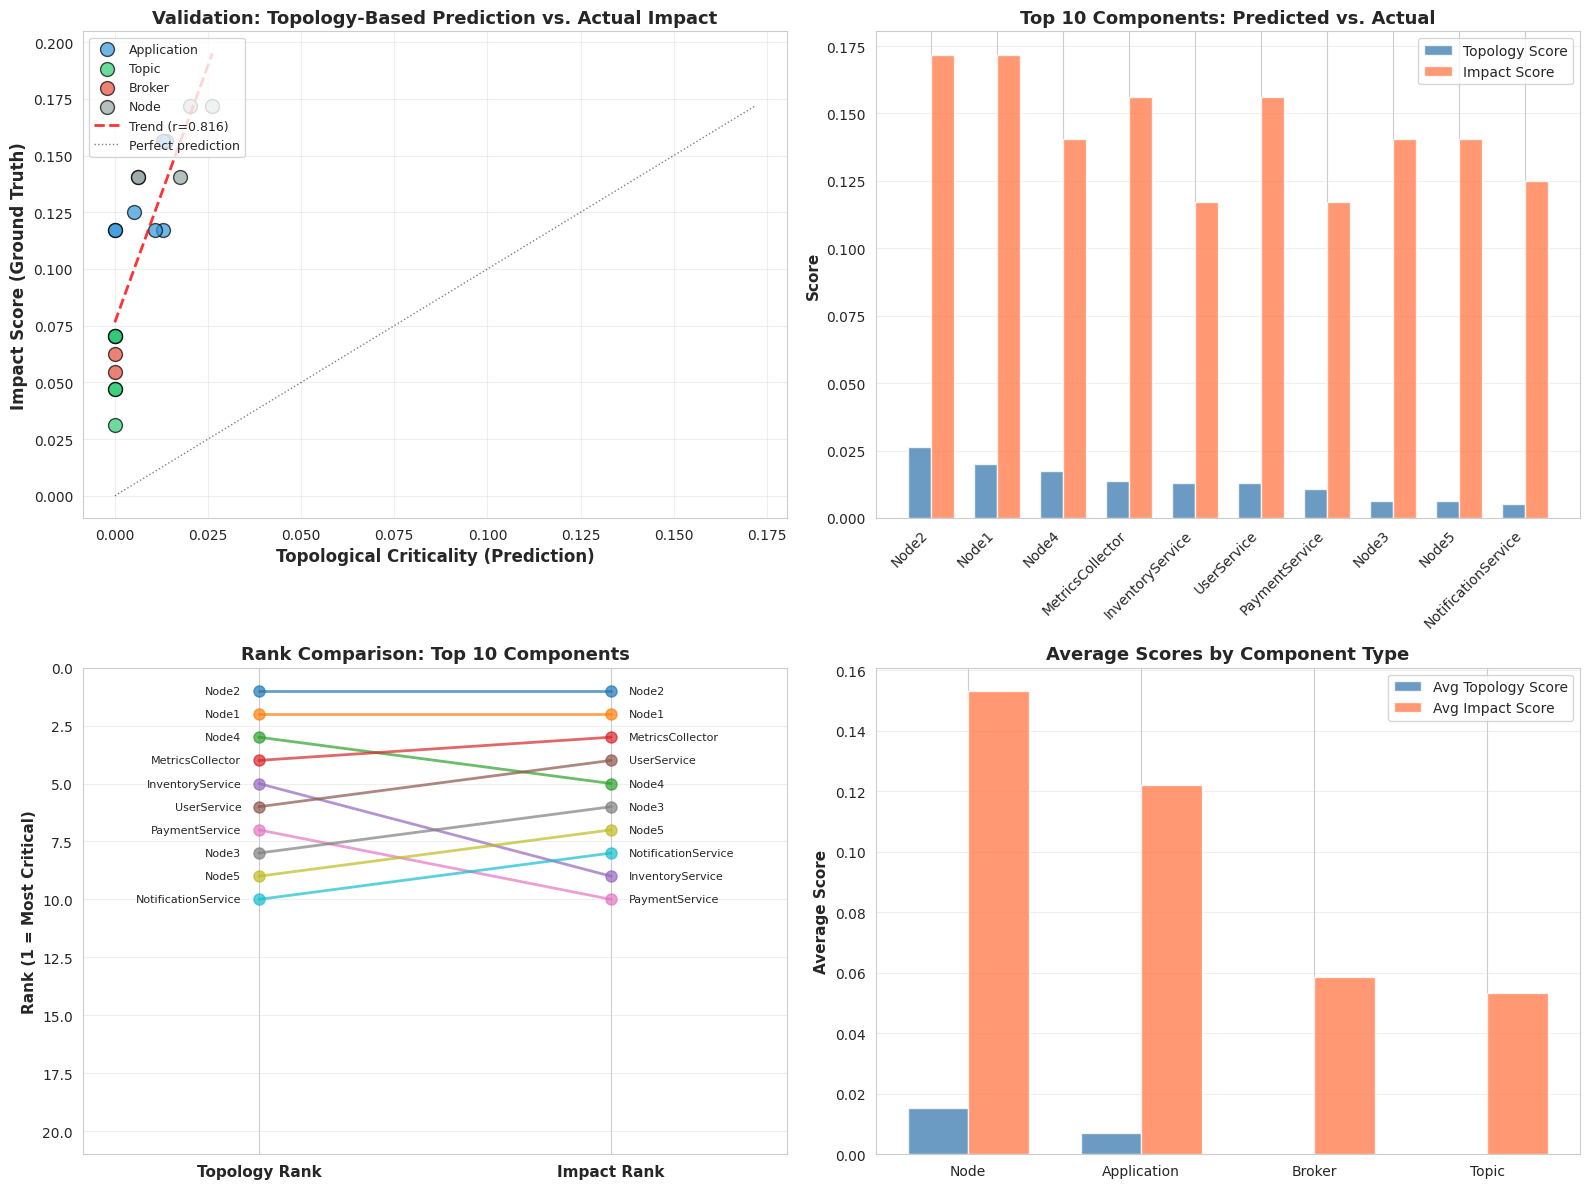


✓ Validation visualizations generated


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Topology vs. Impact
ax = axes[0, 0]
colors = {'Application': '#3498db', 'Topic': '#2ecc71', 
          'Broker': '#e74c3c', 'Node': '#95a5a6'}
for comp_type, color in colors.items():
    mask = topology_df['type'] == comp_type
    ax.scatter(topology_df[mask]['composite_criticality'],
              topology_df[mask]['impact_score'],
              c=color, label=comp_type, s=100, alpha=0.7, edgecolors='black')

# Add trend line
z = np.polyfit(topology_df['composite_criticality'], topology_df['impact_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(topology_df['composite_criticality'].min(), 
                     topology_df['composite_criticality'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8,
        label=f'Trend (r={validation["pearson_r"]:.3f})')

# Diagonal reference line (perfect prediction)
max_val = max(topology_df['composite_criticality'].max(), topology_df['impact_score'].max())
ax.plot([0, max_val], [0, max_val], 'k:', linewidth=1, alpha=0.5, label='Perfect prediction')

ax.set_xlabel('Topological Criticality (Prediction)', fontsize=12, fontweight='bold')
ax.set_ylabel('Impact Score (Ground Truth)', fontsize=12, fontweight='bold')
ax.set_title('Validation: Topology-Based Prediction vs. Actual Impact', 
            fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Bar chart: Top 10 by both metrics
ax = axes[0, 1]
top_10 = topology_df.head(10)
x = np.arange(len(top_10))
width = 0.35
ax.bar(x - width/2, top_10['composite_criticality'], width, 
       label='Topology Score', color='steelblue', alpha=0.8)
ax.bar(x + width/2, top_10['impact_score'], width,
       label='Impact Score', color='coral', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(top_10['name'], rotation=45, ha='right')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Components: Predicted vs. Actual', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 3. Rank comparison
ax = axes[1, 0]
comparison = topology_df.copy()
comparison['topology_rank'] = comparison['composite_criticality'].rank(ascending=False, method='first')
comparison['impact_rank'] = comparison['impact_score'].rank(ascending=False, method='first')
comparison = comparison.sort_values('topology_rank')

for i, row in comparison.head(10).iterrows():
    ax.plot([1, 2], [row['topology_rank'], row['impact_rank']], 
           'o-', linewidth=2, markersize=8, alpha=0.7)
    
    # Annotate
    ax.text(0.95, row['topology_rank'], row['name'], 
           ha='right', va='center', fontsize=8)
    ax.text(2.05, row['impact_rank'], row['name'],
           ha='left', va='center', fontsize=8)

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, len(comparison) + 1)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Topology Rank', 'Impact Rank'], fontsize=11, fontweight='bold')
ax.set_ylabel('Rank (1 = Most Critical)', fontsize=11, fontweight='bold')
ax.set_title('Rank Comparison: Top 10 Components', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='y')

# 4. Component type analysis
ax = axes[1, 1]
type_stats = topology_df.groupby('type').agg({
    'composite_criticality': 'mean',
    'impact_score': 'mean'
}).sort_values('composite_criticality', ascending=False)

x = np.arange(len(type_stats))
width = 0.35
ax.bar(x - width/2, type_stats['composite_criticality'], width,
       label='Avg Topology Score', color='steelblue', alpha=0.8)
ax.bar(x + width/2, type_stats['impact_score'], width,
       label='Avg Impact Score', color='coral', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(type_stats.index, fontsize=10)
ax.set_ylabel('Average Score', fontsize=11, fontweight='bold')
ax.set_title('Average Scores by Component Type', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('topology_validation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Validation visualizations generated")

## 6. Topic Importance Context Analysis

Show how QoS-based topic importance provides context without affecting criticality scores.

In [7]:
# Analyze topics specifically
topics_df = topology_df[topology_df['type'] == 'Topic'].copy()

if len(topics_df) > 0:
    print("\n" + "="*80)
    print("TOPIC IMPORTANCE CONTEXT ANALYSIS")
    print("="*80)
    print("\nQoS importance provides CONTEXT but does NOT affect criticality scores.")
    print("\nTopics Ranked by Criticality vs. QoS Importance:")
    
    topics_comparison = topics_df[['name', 'composite_criticality', 
                                   'qos_importance', 'impact_score']].copy()
    topics_comparison['crit_rank'] = topics_comparison['composite_criticality'].rank(ascending=False)
    topics_comparison['qos_rank'] = topics_comparison['qos_importance'].rank(ascending=False)
    topics_comparison['rank_diff'] = abs(topics_comparison['crit_rank'] - topics_comparison['qos_rank'])
    
    print(topics_comparison.sort_values('composite_criticality', ascending=False).to_string(index=False))
    
    print("\nKey Insights:")
    print(f"  • Correlation (Topology vs QoS): {topics_df['composite_criticality'].corr(topics_df['qos_importance']):.3f}")
    print(f"  • Correlation (Impact vs QoS): {topics_df['impact_score'].corr(topics_df['qos_importance']):.3f}")
    
    # Find mismatches
    high_crit_low_qos = topics_comparison[
        (topics_comparison['composite_criticality'] > topics_comparison['composite_criticality'].median()) &
        (topics_comparison['qos_importance'] < topics_comparison['qos_importance'].median())
    ]
    
    if len(high_crit_low_qos) > 0:
        print("\n  • Topics with HIGH criticality but LOW QoS importance:")
        for _, row in high_crit_low_qos.iterrows():
            print(f"    - {row['name']}: Structural bottleneck despite low QoS requirements")
    
    low_crit_high_qos = topics_comparison[
        (topics_comparison['composite_criticality'] < topics_comparison['composite_criticality'].median()) &
        (topics_comparison['qos_importance'] > topics_comparison['qos_importance'].median())
    ]
    
    if len(low_crit_high_qos) > 0:
        print("\n  • Topics with LOW criticality but HIGH QoS importance:")
        for _, row in low_crit_high_qos.iterrows():
            print(f"    - {row['name']}: Important business requirement but not structural bottleneck")


TOPIC IMPORTANCE CONTEXT ANALYSIS

QoS importance provides CONTEXT but does NOT affect criticality scores.

Topics Ranked by Criticality vs. QoS Importance:
             name  composite_criticality  qos_importance  impact_score  crit_rank  qos_rank  rank_diff
inventory/updates                    0.0            0.90      0.070312        3.0       2.0        1.0
    notifications                    0.0            0.65      0.046875        3.0       4.0        1.0
   metrics/system                    0.0            0.40      0.031250        3.0       5.0        2.0
      user/events                    0.0            0.75      0.046875        3.0       3.0        0.0
   payment/orders                    0.0            0.95      0.070312        3.0       1.0        2.0

Key Insights:
  • Correlation (Topology vs QoS): nan
  • Correlation (Impact vs QoS): 0.961


## 7. Summary and Interpretation

In [8]:
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)

print("\n1. METHODOLOGY")
print("-" * 80)
print("   Composite Criticality: C_score(v) = 0.6·C_B^norm(v) + 0.4·AP(v)")
print("   → Uses ONLY topological structure (betweenness + articulation points)")
print("   → Fast computation, suitable for real-time analysis")
print("\n   Validation: I(v) = 1 - |R(G-v)|/|R(G)|")
print("   → Measures actual reachability loss (ground truth)")
print("   → Slower computation, used for periodic validation")
print("\n   Topic Importance: QoS policies")
print("   → Provides business context for interpretation")
print("   → NOT used in criticality calculation")

print("\n2. VALIDATION RESULTS")
print("-" * 80)
print(f"   Correlation: {validation['pearson_r']:.3f} ({strength})")
print(f"   Top-5 accuracy: {validation['top_k_accuracy']:.1%}")
print(f"   Status: {'✓ PASSED' if validation['validation_passed'] else '✗ FAILED'}")

print("\n3. KEY FINDINGS")
print("-" * 80)
print(f"   • Most critical (topology): {topology_df.iloc[0]['name']} "
      f"(score: {topology_df.iloc[0]['composite_criticality']:.4f})")
impact_sorted = topology_df.sort_values('impact_score', ascending=False)
print(f"   • Highest impact (actual): {impact_sorted.iloc[0]['name']} "
      f"(score: {impact_sorted.iloc[0]['impact_score']:.4f})")
print(f"   • Articulation points: {topology_df['is_articulation_point'].sum()}")

print("\n4. INTERPRETATION")
print("-" * 80)
if validation['validation_passed']:
    print("   ✓ The topological approach is VALIDATED")
    print("   → Pure topology successfully predicts actual impact")
    print("   → Betweenness centrality and articulation points are sufficient")
    print("   → Can use fast topology-based scoring for operations")
    print("   → Periodic impact validation confirms accuracy")
else:
    print("   ⚠ Topological predictions show weak correlation with actual impact")
    print("   → May need to adjust weight parameters (α, β)")
    print("   → Consider graph construction methodology")
    print("   → Evaluate if additional topological metrics needed")

print("\n5. ADVANTAGES OF THIS APPROACH")
print("-" * 80)
print("   • Scientific rigor: Clear separation of prediction and validation")
print("   • Computational efficiency: Fast topology, slower validation")
print("   • Falsifiability: Correlation shows if approach is valid")
print("   • Interpretability: Pure structure easier to explain than mixed metrics")
print("   • Practical: Can use topology daily, validate weekly/monthly")

print("\n" + "="*80)


COMPREHENSIVE SUMMARY

1. METHODOLOGY
--------------------------------------------------------------------------------
   Composite Criticality: C_score(v) = 0.6·C_B^norm(v) + 0.4·AP(v)
   → Uses ONLY topological structure (betweenness + articulation points)
   → Fast computation, suitable for real-time analysis

   Validation: I(v) = 1 - |R(G-v)|/|R(G)|
   → Measures actual reachability loss (ground truth)
   → Slower computation, used for periodic validation

   Topic Importance: QoS policies
   → Provides business context for interpretation
   → NOT used in criticality calculation

2. VALIDATION RESULTS
--------------------------------------------------------------------------------
   Correlation: 0.816 (STRONG)
   Top-5 accuracy: 80.0%
   Status: ✓ PASSED

3. KEY FINDINGS
--------------------------------------------------------------------------------
   • Most critical (topology): Node2 (score: 0.0262)
   • Highest impact (actual): Node2 (score: 0.1719)
   • Articulation points:

## Conclusion

### **Does This Approach Make Sense? YES!**

This refined methodology is **scientifically superior** to mixing impact scores into the composite calculation:

#### **Why It's Better**

1. **Separation of Concerns**: Prediction (topology) is distinct from validation (impact)
2. **Computational Efficiency**: O(n) topology vs. O(n²) impact - use fast method operationally
3. **Scientific Validity**: Can measure if topology actually predicts real impact
4. **Falsifiable**: Low correlation reveals methodological problems
5. **Practical Utility**: Daily topology scoring + periodic impact validation

#### **Role of Each Metric**

- **Betweenness Centrality + Articulation Points**: Core prediction (fast, structural)
- **Impact Score**: Ground truth validation (slow, comprehensive)
- **QoS Importance**: Business context (helps interpret results)

#### **When to Use What**

- **Real-time monitoring**: Topology-based criticality (fast)
- **Weekly/monthly validation**: Impact score calculation (comprehensive)
- **Decision making**: Consider topology score + QoS importance context
- **Research**: Validate approach with correlation analysis

This approach provides both **operational speed** and **scientific rigor**!